based on https://pennylane.ai/qml/demos/tutorial_qcbm#liu

# Definitions

Let $\{x'\}$ be a dataset of samples drawn, indipendently, from the same unknown probability distribution $\pi(x')$. We want to approximate it with a QCBM, treated as an implicit generative model, returning a parametrized quantum state $\ket{\psi(\theta)}$, that we sample to get our probability distribution $p(\theta)$. To train the circuit we need a loss function comparing the two functions, one possible choice is Maximum Mean Discrepancy. In general, MMD is defined by the idea of representing distances between distributions as distances between mean embeddings of features. The MMD is zero if and only if the two distributions are the same.
$$ L(\theta) = \left\| \sum_x p_\theta(x) \phi(x) - \sum_x \pi(x) \phi(x) \right\|^2 $$



<p align="center">
  <img src="./img/img_1.1.png" alt="image 1.1" />
</p>


For computational and analytical convenience we can reconduct the procedure to the calculation of a kernel function:
$$ K(x, y) = \frac{1}{c} \sum_{i=1} \exp\left(\frac{|x - y|^2}{2 \sigma_i^2}\right) $$

where we are avaraging over multiple possible gaussians. We can rewrite the expression for L in terms of K:

$$ L = \mathbb{E}_{x\sim p_\theta, y \sim p_\theta} \left[ K(x, y) \right] - 2 \mathbb{E}_{x \sim p_\theta, y \sim \pi} \left[ K(x, y) \right] + \mathbb{E}_{x\sim \pi, y \sim \pi} \left[ K(x, y) \right] = $$
$$ =\sum_{x, y} p(x) p(y) K(x, y)-2 \sum_{x, y} p(x) \pi(y) K(x, y)+\sum_{x, y} \pi(x) \pi(y) K(x, y)= $$
$$ = \sum_{x, y} K(x, y)(p(x) p(y)-2 p(x) \pi(y)+\pi(x) \pi(y))= $$
$$ = \sum_{x, y} K(x, y)(p(x)-\pi(x))(p(y)-\pi(y)) $$



In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)


class MMD:

    # Function init takes a list of sigma values and a "space vector", containing all possible states in the hilbert 
    # space: space = (1,...,2^#qubits-1). We will calculate all possible distances between states in the space vector, 
    # summing the kernel function for each sigma value, to get the kernel matrix K. The operation space[:, None] - space[None, :]
    # means the "difference" between a row and a column vector, returning a matrix with all possible differences between states.

    def __init__(self, SigmaVector, space):
        gammas = 1 / (2 * (SigmaVector**2))

        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2 

        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(SigmaVector)
        self.SigmaVector = SigmaVector

    # Function KExpVal calculates the expectation value of the K(x,y) kernel function, where x and y are drawn from px and py
    # distributions, respectively. Brief proof of the expectation value calculation for 2 states 0 and 1:
    # K = (k00,k01)
    #     (k10,k11)
    # px = (px0,px1)
    # py = (py0,py1)
    # KExpVal = px0*py0*k00 + px0*py1*k01 + px1*py0*k10 + px1*py1*k11 = sum(px_i*py_j*kij) for i,j summed over all states (0,1).
         
    def KExpVal(self, px, py):
        return px @ self.K @ py

    # Function __call__ (that is called as MMD() function) calculates the MMD between two distributions px and py, where px and py
    # are probability vectors (using relaboration proves above).

    def __call__(self, px, py):
        pxy = px - py
        return self.KExpVal(pxy, pxy)

Let's define the Quantum Circuit Born Machine as an object that takes in input a parametrized quantum circuit, a loss calculation method and a target distribution, returning the loss value:

<p align="center">
  <img src="./img/img_1.2.png" alt="image 1.1" />
</p>

In [3]:
from functools import partial

class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ    # our parametric quantum circuit
        self.mmd = mmd      # our loss calculation method
        self.py = py        # target distribution π(x)

    @partial(jax.jit, static_argnums=0) # decorator to speed up the optimization process keeping 1st argument fixed
    def MMD_loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px


## Define synthetic dataset
Let's define a dataset to train our system. We can use a simple dataset of length 9 bit-strings, that we can represent as 3x3 stripes and bars pixel images. It will contain 14 points, over the $2^n$ possible states. The system will therefore consist of 9 qubits.


Sample bitstring: 100100100


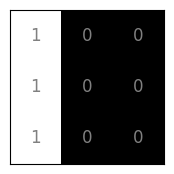

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)
    
    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))


#Parameters
n = 3
size = n**2
data = get_bars_and_stripes(n)
sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")



The dataset includes 14 examples, therefore the target probability distribution is:

$\pi(x) = \sum_{i=1} ^ {14} \frac{1}{14} \delta_{x,i} $. We can assign an integer to every possible combination, from 0 to 511, and plot the probability distribution.

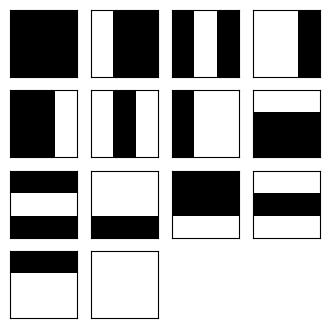

In [6]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])


In [7]:
bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
print(nums)


[0, 292, 146, 438, 73, 365, 219, 448, 56, 504, 7, 455, 63, 511]


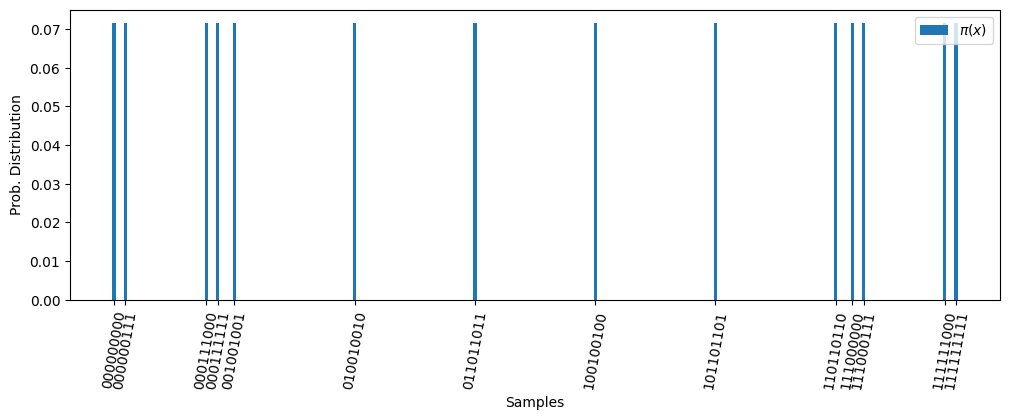

In [8]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$")
plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()


## Quantum circuit

Here we define the quantum circuit acting as "generative model" in our QCBM.

In [11]:
import pennylane as qml

np.random.seed(42)

n_qubits = size
dev = qml.device("default.qubit", wires=n_qubits) #simple simulator of n qubit system

# Strongly Entangling Layer
# ansatz for the quantum circuit, layers consisting of single qubit rotations and entanglers, inspired by 
# the circuit-centric classifier design arXiv:1804.00633.

n_layers = 6
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape) # random 6x9x3 tensor


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.probs()

jit_circuit = jax.jit(circuit)


# Training

Let's set up the QCBM and choose optimization algorithm.

In [13]:
import optax

#Parameters
bandwidth = jnp.array([0.25, 0.5, 1])   # sigmas for the Gaussian kernel
space = jnp.arange(2**n_qubits)         # space vector containing all possible states in the hilbert space

#Setting up the MMD and QCBM
mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, probs)

#Optimization via Adam
opt = optax.adam(learning_rate=0.1)     
opt_state = opt.init(weights)

We define the update_step method which
- computes the squared MMD loss and gradients.
- apply the update step of our optimizer.
- updates the parameter values.
- calculates the KL divergence.

The KL divergence is a measure of how far the predicted distribution pθ(x)
is from the target distribution π(x).

In [14]:
@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.MMD_loss, has_aux=True)(params) #return loss, gradients and prob. vector
    updates, opt_state = opt.update(grads, opt_state)                                       #update weights 
    params = optax.apply_updates(params, updates)                                           #update weights
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))              #KL divergence    
    return params, opt_state, loss_val, kl_div

mmd
history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0684 KL-div: 4.0735
Step: 10 Loss: 0.0439 KL-div: 1.7351
Step: 20 Loss: 0.0367 KL-div: 1.3296
Step: 30 Loss: 0.0292 KL-div: 1.0619
Step: 40 Loss: 0.0116 KL-div: 0.4977
Step: 50 Loss: 0.0039 KL-div: 0.2462
Step: 60 Loss: 0.0014 KL-div: 0.1348
Step: 70 Loss: 0.0009 KL-div: 0.1077
Step: 80 Loss: 0.0006 KL-div: 0.0852
Step: 90 Loss: 0.0004 KL-div: 0.0755


We can see from the plots that the training resulted in a minimization of both loss and KL divergence, meaning $p(\theta)$ is getting closer to $\pi$

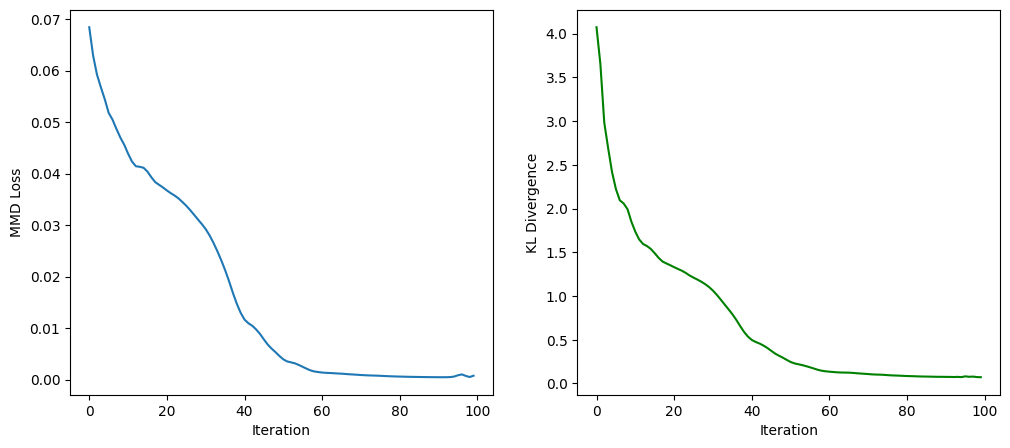

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(history)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MMD Loss")

ax[1].plot(divs, color="green")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("KL Divergence")
plt.show()

We can also print the two distribution to compare them:

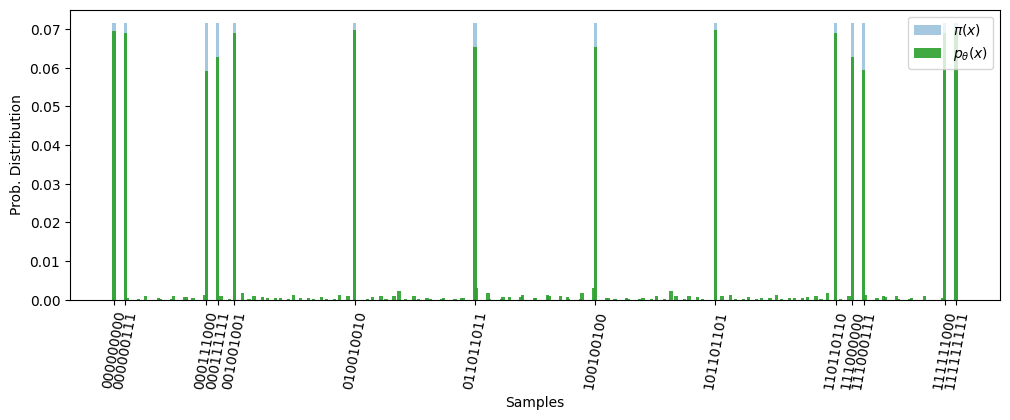

In [16]:
qcbm_probs = np.array(qcbm.circ(weights))

plt.figure(figsize=(12, 5))

plt.bar(
    np.arange(2**size),
    probs,
    width=2.0,
    label=r"$\pi(x)$",
    alpha=0.4,
    color="tab:blue",
)
plt.bar(
    np.arange(2**size),
    qcbm_probs,
    width=2.0,
    label=r"$p_\theta(x)$",
    alpha=0.9,
    color="tab:green",
)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.xticks(nums, bitstrings, rotation=80)
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()


# Testing

We can test the circuit producing samples. We can mesure $\psi(\theta)$ 64 times to compose an 8x8 diagram of corresponding images.

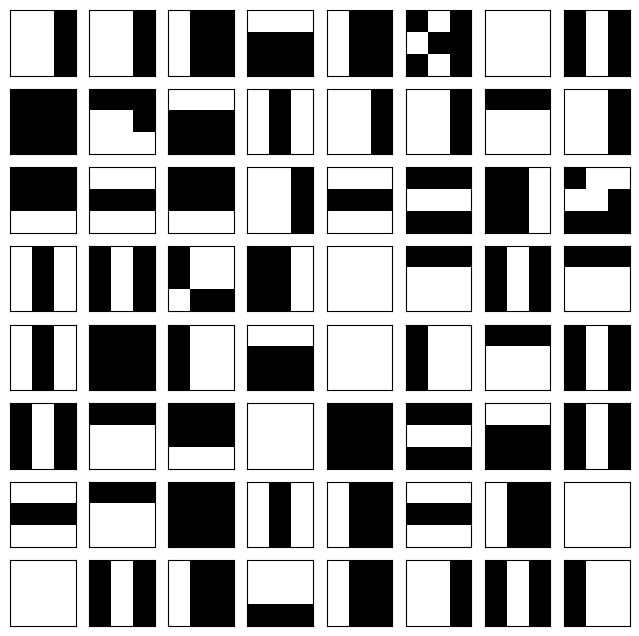

In [17]:
def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.sample()


dev = qml.device("default.qubit", wires=n_qubits, shots=64)
circ = qml.QNode(circuit, device=dev)
preds = circ(weights)

plt.figure(figsize=(8, 8))
j = 1
for i in preds[:64]:
    ax = plt.subplot(8, 8, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])


With just a few attempts we can see that some of the diagrams are not rows or stripes, states in $p(\theta)$ with nonzero probabilities, not present in $\pi$.

# Example: gaussian function

Let $\pi(x) \propto e^{-\frac{1}{2}\left(\frac{x-\mu_1}{\sigma}\right)^2}+e^{-\frac{1}{2}\left(\frac{x-\mu_2}{\sigma}\right)^2}$.
with x ranging from 0 to $2^n-1$.

In [18]:
#Parameters
n = 6
x_input = np.arange(2**n)
mus = [2/7* 2**n, 5/7* 2**n]
sigmas = [2**n /8] * 2

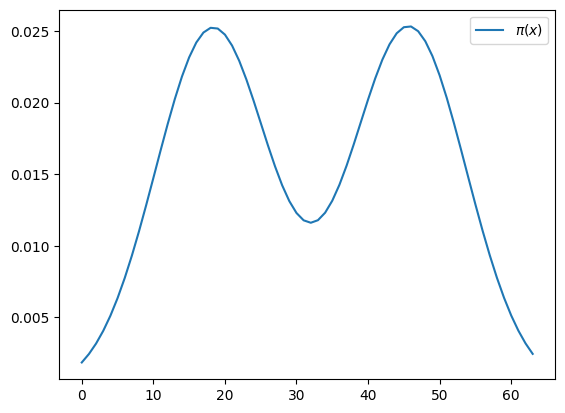

In [19]:
# Defining gaussians_pdf to calculate the pdf from parameters. x is a vector of states.

def gaussians_pdf(x, muVec, sigmaVec):
    muVec, sigmaVec = np.array(muVec), np.array(sigmaVec)
    values = [1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2) for mu, sigma in zip(muVec, sigmaVec)]
    values = np.sum([val/sum(val) for val in values], axis=0)   #normalize single gaussians
    return values/sum(values)                                   #retun normalized sum of gaussians


data = gaussians_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

Here we just repeat the initialization as before and train over the new distrbution.

In [20]:
import pennylane as qml
np.random.seed(42)

dev = qml.device("default.qubit", wires=n)

n_layers = 4
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

In [21]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0218 KL-div: 1.1215
Step: 10 Loss: 0.0041 KL-div: 0.3619
Step: 20 Loss: 0.0022 KL-div: 0.1970
Step: 30 Loss: 0.0012 KL-div: 0.1083
Step: 40 Loss: 0.0007 KL-div: 0.0870
Step: 50 Loss: 0.0004 KL-div: 0.0428
Step: 60 Loss: 0.0003 KL-div: 0.0373
Step: 70 Loss: 0.0002 KL-div: 0.0304
Step: 80 Loss: 0.0002 KL-div: 0.0252
Step: 90 Loss: 0.0002 KL-div: 0.0229


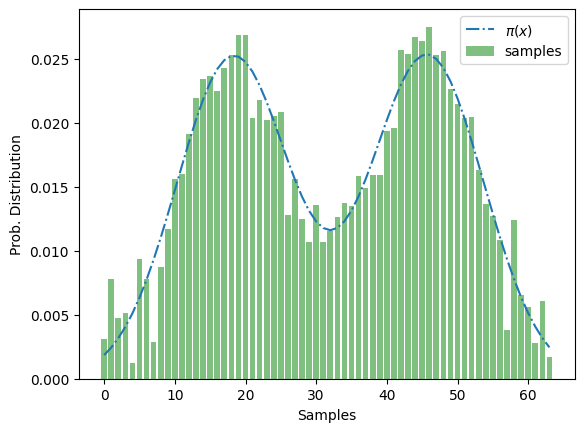

In [22]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(2**n), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(2**n), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()
